In [7]:
# Import API modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import geopandas as gpd
# Import linestrings
import tradeAreasPreprocessing as tap
from shapely.geometry import LineString
import census_finder

In [ ]:
# Read token.txt
with open("inrix_token.txt", "r") as f:
    token = f.read()

# Use API
endpoint = f"https://api.iq.inrix.com/v1/segments/speed?box=37.757386%7C-122.490667%2C37.746138%7C-122.395481"
r = requests.get(endpoint, headers={'Authorization': f"Bearer {token}"})

In [ ]:
od = 'origin'
geoFilterType = 'polygon'
radius = '0.2km'
points = '37.734622%7C-122.471603%2C37.743627%7C-122.463850%2C37.743066%7C-122.475429'
providerType = 'consumer'
startDateTime = '%3E%3D2023-06-01T02%3A31'
endDateTime = '%3C%3D2023-06-15T02%3A31'

# Trade Areas API
endpoint_TA = f'https://api.iq.inrix.com/v1/trips?od={od}&geoFilterType={geoFilterType}&radius={radius}&points={points}&providerType={providerType}&startDateTime={startDateTime}&endDateTime={endDateTime}'
r_TA = requests.get(endpoint_TA, headers={'Authorization': f"Bearer {token}"})

In [ ]:
# Convert dictionary to dataframe
df = pd.DataFrame.from_dict(r_TA.json()['data'])


In [ ]:
# Separate startLoc into two columns: all numbers before comma and all numbers after comma, then convert to floats
df['start_lat'] = df['startLoc'].apply(lambda x: x.split(',')[0]).astype(float)
df['start_lon'] = df['startLoc'].apply(lambda x: x.split(',')[1]).astype(float)
df['end_lat'] = df['endLoc'].apply(lambda x: x.split(',')[0]).astype(float)
df['end_lon'] = df['endLoc'].apply(lambda x: x.split(',')[1]).astype(float)

# Create linestring from start and end coordinates
df['geometry'] = df.apply(lambda x: LineString([(x['start_lon'], x['start_lat']), (x['end_lon'], x['end_lat'])]), axis=1)

In [ ]:
# Read geojson
sf = gpd.read_file('San_Francisco_Bay_Region_2020_Census_Tracts.geojson')

In [ ]:
# Convert df to geopandas
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Find intersection of linestring and geojson
sf['intersections'] = sf.geometry.clip(df.geometry)

In [ ]:
sf[sf['intersections'].notnull()].intersections

### Temporal Processing

In [ ]:
df['startDateTime'] = pd.to_datetime(df['startDateTime'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['endDateTime'] = pd.to_datetime(df['endDateTime'], format='%Y-%m-%dT%H:%M:%S.%fZ')

df['duration'] = (df['endDateTime'] - df['startDateTime']).dt.total_seconds()

df['day'] = df['startDateTime'].dt.day
df['month'] = df['startDateTime'].dt.month
df['year'] = df['startDateTime'].dt.year
df['dow'] = df['startDateTime'].dt.dayofweek
df['start_hour'] = df['startDateTime'].dt.hour
df['end_hour'] = df['endDateTime'].dt.hour
df['start_date'] = df['startDateTime'].dt.date
df['end_date'] = df['endDateTime'].dt.date
df['weekend'] = df['dow'].apply(lambda x: 1 if x >= 5 else 0)

## Weather API?

In [ ]:
with open("weather_token.txt", "r") as f:
    weather_token = f.read()

date = '2023-11-29'

city = 'San Francisco'
# Use API
endpoint_weather = f"http://api.weatherapi.com/v1/history.json?key={weather_token}&q={city}&dt={date}"
r_weather = requests.get(endpoint_weather)

r_weather.json()

In [ ]:
# Read as dataframe
df_weather = pd.DataFrame.from_dict(r_weather.json()['forecast']['forecastday'][0]['hour'])

In [ ]:
df_weather

In [4]:

# Read token.txt
with open("inrix_token.txt", "r") as f:
    token = f.read()
    
# Initialize class
tap = tap.tradeAreasPreprocessing(token=token,
                                  od = 'origin', 
                                  geoFilterType = 'polygon',
                                radius = '0.2km',
                                points = '37.734622%7C-122.471603%2C37.743627%7C-122.463850%2C37.743066%7C-122.475429',
                                providerType = 'consumer',
                                startDateTime = '%3E%3D2023-06-01T02%3A31',
                                endDateTime = '%3C%3D2023-06-15T02%3A31')

# Read data
df = tap.read_data()

AttributeError: 'tradeAreasPreprocessing' object has no attribute 'tradeAreasPreprocessing'

In [3]:
df = tap.create_dataframe(df)

KeyError: 'data'

In [4]:
df = tap.separate_coordinates(df)

df = tap.add_temporal_vars(df)

#df = tap.add_mode(df)

In [5]:
trips_gdf = tap.get_trip_geometry(df)

ca_tiger = tap.downloadShapefile()

Using FIPS code '06' for input 'CA'


In [6]:
intersected_trips = tap.intersectedTrips(trips_gdf, ca_tiger)

In [32]:
# Reload magic functions
%reload_ext autoreload
%autoreload 2

In [4]:
# read in files
geojson_location = "/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GeoAdVisor/sf-tracts-2020-clipped.geojson"
census_data = "/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GeoAdVisor/census_data/census_data_clean.csv"

# Load the GeoJSON file into a GeoDataFrame and csv into df
gdf = gpd.read_file(geojson_location)
census_df = pd.read_csv(census_data, dtype={"tract": str})

# Filter out invalid geometries
gdf = gdf[gdf.is_valid]

# INitialize class
cf = census_finder.censusFinder(gdf, census_df)

tract_no = cf.get_census_tract_info(37.734622, -122.471603)

demographics = cf.lookup_demographics(tract_no)

In [5]:
demographics.columns

Index(['tract', 'Median Household Income', 'total_pop', 'pct_female',
       'pct_male', 'pct_children', 'pct_20-39', 'pct_39-64', 'pct_65+',
       'pct_nonwhite', 'pct_latine'],
      dtype='object')

In [115]:
def append_demographics(row):
    tract_no = cf.get_census_tract_info(row['start_lat'], row['start_lon'])
    demographics = cf.lookup_demographics(tract_no)
    return demographics.iloc[0]

demographics_df = df.apply(append_demographics, axis=1)

result_df = pd.concat([intersected_trips, demographics_df], axis=1).iloc[:, :37]

In [96]:
def append_demographics(row):
    tract_no = cf.get_census_tract_info(row['start_lat'], row['start_lon'])
    demographics = cf.lookup_demographics(tract_no)
    demo_series = demographics.iloc[0]
    demo_series.index = ['tract', 'Median Household Income', 'total_pop', 'pct_female', 'pct_male', 'pct_children', 'pct_20-39', 'pct_39-64', 'pct_65+', 'pct_nonwhite', 'pct_latine'] 
    return demo_series
demographics_df = df.apply(append_demographics, axis=1)
result_df = pd.concat([df.reset_index(drop=True), demographics_df.reset_index(drop=True)], axis=1).iloc[:, :37]

In [22]:

# Example usage
latitude = 37.743138  # Replace with actual latitude
longitude = -122.466007  # Replace with actual longitude
census_tract_info = census_finder.get_census_tract_info(latitude, longitude, gdf)


In [23]:
census_tract_info

{'TRACTCE20': '030800'}

In [2]:
demographics

NameError: name 'demographics' is not defined

In [19]:
intersected_trips[intersected_trips['tripId'] == 'dd8ed7439a33ebe0797e23cb7918ec21']

,tripId,GEOID,geometry_x,geometry_y,line_locs
3658,dd8ed7439a33ebe0797e23cb7918ec21,06075030800,"POLYGON ((-122.47573 37.74305, -122.47558 37.7...","LINESTRING (-122.46601 37.74314, -122.50049 37...","(0.0, 1094.7372454378553)"
3659,dd8ed7439a33ebe0797e23cb7918ec21,06075033001,"POLYGON ((-122.49451 37.74222, -122.49436 37.7...","LINESTRING (-122.46601 37.74314, -122.50049 37...","(2878.403871091762, 3208.2974503973883)"
3660,dd8ed7439a33ebe0797e23cb7918ec21,06075033002,"POLYGON ((-122.49129 37.73730, -122.49090 37.7...","LINESTRING (-122.46601 37.74314, -122.50049 37...","(1094.7372454378553, 2878.403871091762)"
3661,dd8ed7439a33ebe0797e23cb7918ec21,06075060400,"POLYGON ((-122.51273 37.73509, -122.51008 37.7...","LINESTRING (-122.46601 37.74314, -122.50049 37...","(3931.2131256589555, 3934.2353148580683)"
3662,dd8ed7439a33ebe0797e23cb7918ec21,06075035300,"POLYGON ((-122.50193 37.74938, -122.50086 37.7...","LINESTRING (-122.46601 37.74314, -122.50049 37...","(3208.2974503973883, 3931.2131256589555)"


In [12]:
import altair as alt

geojson_location = "/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GeoAdVisor/sf-tracts-2020-clipped.geojson"
geometry = gpd.read_file(geojson_location)
data = pd.read_csv('origin_demographics.csv')


In [19]:
geometry['TRACTCE20'] = geometry['TRACTCE20'].astype(int)

In [21]:

merged_data = geometry.merge(data, left_on='TRACTCE20', right_on='tract', how='left')
merged_data

,TRACTCE20,geometry,providerHash,startLoc,startDateTime,endLoc,endpointType,tripDistanceMeters,tripMeanSpeedKPH,tripId,...,Median Household Income,total_pop,pct_female,pct_male,pct_children,pct_20-39,pct_39-64,pct_65+,pct_nonwhite,pct_latine
0,23300,"MULTIPOLYGON (((-122.39987 37.73029, -122.4021...",98b297950041a42470269d56260243a1,"37.72665,-122.393829",2023-06-01 03:33:07.000,"37.922606,-122.061308",1.0,47122.0,64.0,88ba08c9be12cd16aa4c49fe583280f5,...,67279.0,3930.0,0.502036,0.497964,0.114758,0.025700,0.166667,0.093130,0.889313,0.215522
1,23300,"MULTIPOLYGON (((-122.39987 37.73029, -122.4021...",0353ab4cbed5beae847a7ff6e220b5cf,"37.7267,-122.394",2023-06-01 04:36:39.000,"37.024,-121.564",3.0,172889.0,87.0,155d3b4b494c3fb4aaff7586a40c37a2,...,67279.0,3930.0,0.502036,0.497964,0.114758,0.025700,0.166667,0.093130,0.889313,0.215522
2,23300,"MULTIPOLYGON (((-122.39987 37.73029, -122.4021...",98b297950041a42470269d56260243a1,"37.724185,-122.394971",2023-06-01 14:13:51.000,"37.434785,-122.179181",3.0,49995.0,83.0,671ac5addde1e682ae8d8eebbeae075e,...,67279.0,3930.0,0.502036,0.497964,0.114758,0.025700,0.166667,0.093130,0.889313,0.215522
3,23300,"MULTIPOLYGON (((-122.39987 37.73029, -122.4021...",c3e878e27f52e2a57ace4d9a76fd9acf,"37.724993,-122.396125",2023-06-01 14:49:20.596,"37.730983,-122.391972",2.0,796.0,8.0,c9bbf4166a99e5e561ab1b36422cdf9e,...,67279.0,3930.0,0.502036,0.497964,0.114758,0.025700,0.166667,0.093130,0.889313,0.215522
4,23300,"MULTIPOLYGON (((-122.39987 37.73029, -122.4021...",0353ab4cbed5beae847a7ff6e220b5cf,"37.7283,-122.4",2023-06-01 15:55:54.000,"37.651,-122.481",1.0,16492.0,56.0,593314aba44bcb1544b5d9eec78c8af4,...,67279.0,3930.0,0.502036,0.497964,0.114758,0.025700,0.166667,0.093130,0.889313,0.215522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195563,13101,"MULTIPOLYGON (((-122.42689 37.79627, -122.4258...",c3e878e27f52e2a57ace4d9a76fd9acf,"37.795684,-122.42677",2023-06-02 18:43:46.663,"37.429976,-122.120482",3.0,55068.0,52.0,f401e4b215ac3ecf9d0ec1332e303660,...,211765.0,4088.0,0.521037,0.478963,0.077789,0.022994,0.297945,0.045254,0.328033,0.062378
195564,13101,"MULTIPOLYGON (((-122.42689 37.79627, -122.4258...",c3e878e27f52e2a57ace4d9a76fd9acf,"37.792101,-122.425135",2023-06-02 20:03:50.080,"37.864861,-122.497879",3.0,11751.0,32.0,2433dc1e609ec19fb972730724f36771,...,211765.0,4088.0,0.521037,0.478963,0.077789,0.022994,0.297945,0.045254,0.328033,0.062378
195565,13101,"MULTIPOLYGON (((-122.42689 37.79627, -122.4258...",c3e878e27f52e2a57ace4d9a76fd9acf,"37.793237,-122.426252",2023-06-02 20:13:48.531,"37.791059,-122.432599",0.0,608.0,12.0,d3924045db4ec57627e446ce1b3ac926,...,211765.0,4088.0,0.521037,0.478963,0.077789,0.022994,0.297945,0.045254,0.328033,0.062378
195566,13101,"MULTIPOLYGON (((-122.42689 37.79627, -122.4258...",f4f6dce2f3a0f9dada0c2b5b66452017,"37.79589,-122.423533",2023-06-02 21:36:11.000,"37.786061,-122.422822",0.0,1268.0,11.0,3b287fe23c68f9f67d9268a328bc22da,...,211765.0,4088.0,0.521037,0.478963,0.077789,0.022994,0.297945,0.045254,0.328033,0.062378


<Axes: >

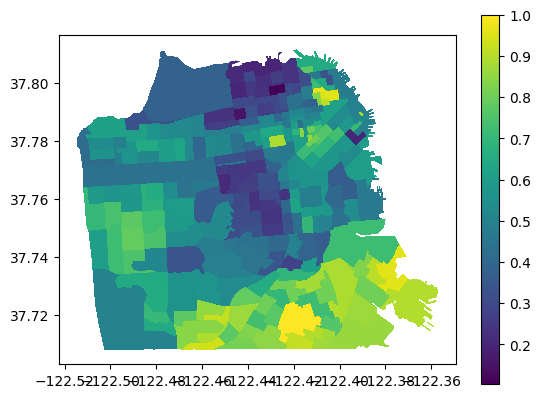

In [25]:
merged_data.plot(column="pct_nonwhite", legend=True)

In [20]:

# Create an Altair chart
chart = alt.Chart(merged_data).mark_geoshape().encode(
    color='pct_female:Q',
    tooltip=['TRACTCE20:N', 'pct_female:Q']
).properties(
    width=500,
    height=500
)
time_slider = alt.binding_range(min=merged_data['hour'].min(), max=merged_data['hour'].max(), step=1)
slider_selection = alt.selection_single(bind=time_slider, fields=['hour'], name='Hour of day')
chart = chart.add_selection(
    slider_selection
).transform_filter(
    slider_selection
)

KeyError: 'hour'